In [1]:
#Downgrade numpy to a compatible version to make sure that pandas-ta works because it doesn't work with the newest version of numpy atm
!pip install numpy==1.24.3 --force-reinstall

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 64.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.3 which is incompatible.
pymc 5.23.0 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.3 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 whic

In [1]:
pip install alpaca-py pandas ta python-dotenv

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.8/121.8 kB 5.4 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=1938a2a0f9dcdca8c7beb581e75e5870665802b2ecb1d35333470fea739f1bb3
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [34]:
!pip install pandas-ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=9767d1bf8bd1441a72ae8a328046535ff06eeb1037155172a14d76a1e3b6386f
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas-ta


In [64]:
import os
from datetime import datetime, timedelta
import pandas as pd
from dotenv import load_dotenv
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
import ta
import numpy as np

In [3]:
ALPACA_API_KEY = "PKJ19Q32UZOUOKLX2EJ2"
ALPACA_SECRET_KEY = "aUTwOhq1ug2rKo0VtmzgBflgcqBHHS3EstiJWFSx"

In [4]:
#Initialize Alpaca Historical Data Client
client = StockHistoricalDataClient(
    api_key=ALPACA_API_KEY,
    secret_key=ALPACA_SECRET_KEY
)
# Config
symbol = "SPY"
timeframe = TimeFrame.Minute  # Change to TimeFrame.Day, .Hour, etc. later
lookback_days = 7000  # You can increase this later
# Pull historical bars
start_date = datetime.today() - timedelta(days=lookback_days)
request_params = StockBarsRequest(
    symbol_or_symbols=symbol,
    timeframe=timeframe,
    start=start_date
)


In [148]:
bars = client.get_stock_bars(request_params).df
df = bars[bars.index.get_level_values(0) == symbol].copy().reset_index()
df.rename(columns={"timestamp": "datetime"}, inplace=True)

In [149]:
df = df.resample('120min', on='datetime').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}).dropna().reset_index()

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_trend_labels(df, price_col='close', window=7):
    df = df.copy()

    # Detect local peaks and troughs
    df['is_peak'] = ((df[price_col].shift(window) < df[price_col]) &
                     (df[price_col].shift(-window) < df[price_col])).fillna(False)

    df['is_trough'] = ((df[price_col].shift(window) > df[price_col]) &
                       (df[price_col].shift(-window) > df[price_col])).fillna(False)

    # Collect reversal points
    peaks = df[df['is_peak']].index.tolist()
    troughs = df[df['is_trough']].index.tolist()
    reversals = sorted(peaks + troughs)
    reversals = [i for i in reversals if i > window and i < len(df) - window]

    # Label trends between reversals: 1 = uptrend, -1 = downtrend
    trend_labels = np.full(len(df), np.nan)
    for i in range(len(reversals) - 1):
        start = reversals[i]
        end = reversals[i + 1]
        if df.loc[start, price_col] < df.loc[end, price_col]:
            trend_labels[start:end] = 1  # uptrend
        else:
            trend_labels[start:end] = -1  # downtrend

    df['trend_label'] = trend_labels
    df = df.drop(columns=['is_peak', 'is_trough'])
    df = df.dropna(subset=['trend_label'])
    df['trend_label'] = df['trend_label'].astype(int)
    df = df.reset_index(drop=True)

    return df

def plot_trends_only(df, price_col='close', last_n=None):
    if last_n is not None:
        df = df.tail(last_n).copy()

    prices = df[price_col].values
    x = np.arange(len(df))
    trend_labels = df['trend_label'].values

    plt.figure(figsize=(15,6))
    plt.plot(x, prices, label='Close Price', color='black')

    def find_segments(labels, target_label):
        segments = []
        start = None
        for i, val in enumerate(labels):
            if val == target_label:
                if start is None:
                    start = i
            else:
                if start is not None:
                    segments.append((start, i-1))
                    start = None
        if start is not None:
            segments.append((start, len(labels)-1))
        return segments

    bullish_segments = find_segments(trend_labels, 1)
    bearish_segments = find_segments(trend_labels, -1)

    for start, end in bullish_segments:
        plt.axvspan(start, end, color='green', alpha=0.1)
    for start, end in bearish_segments:
        plt.axvspan(start, end, color='red', alpha=0.1)

    plt.legend()
    plt.title(f'Price with Trend Segments (Last {last_n} rows)' if last_n else 'Full Trend Segments')
    plt.xlabel('Index')
    plt.ylabel('Price')
    plt.show()



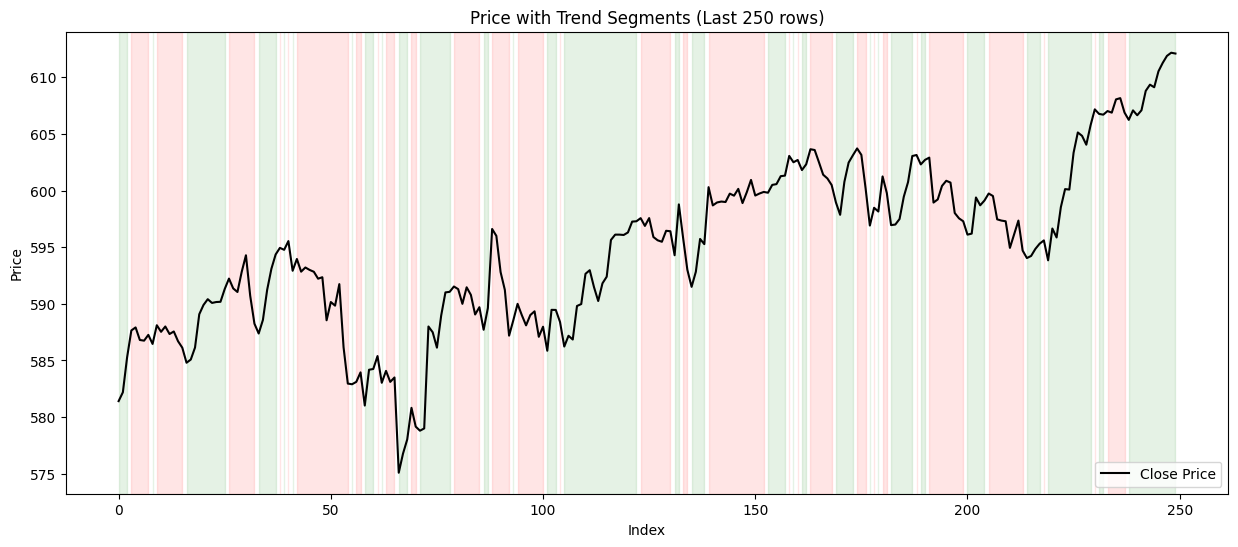

In [151]:
# Assuming you have a DataFrame `df` with a 'close' column
df = generate_trend_labels(df)
plot_trends_only(df, last_n=250)


In [101]:
df.reset_index(drop=True, inplace=True)

In [152]:
# Set datetime as the index (important for VWAP)
df.set_index('datetime', inplace=True)

In [153]:
# Sort the DataFrame by datetime to ensure it is ordered
df.sort_index(inplace=True)

In [154]:
import ta
import pandas_ta as ta

In [155]:
#PRICE ACTION FEATURES
df['price_change_pct'] = df['close'].pct_change()
df['momentum_5'] = df['close'] - df['close'].shift(5)
df['momentum_10'] = df['close'] - df['close'].shift(10)
df['rolling_return_5'] = df['close'].pct_change(periods=5)
df['rolling_return_10'] = df['close'].pct_change(periods=10)

In [156]:
#MOVING AVERAGES
df['sma_50'] = ta.sma(df['close'], length=50)

In [157]:
#VOLATILITY METRICS
df['std_5'] = df['close'].rolling(5).std()
df['std_10'] = df['close'].rolling(10).std()
df['std_20'] = df['close'].rolling(20).std()
df['atr'] = ta.atr(df['high'], df['low'], df['close'], length=14)


In [158]:
#MACD FEATURES
macd = ta.macd(df['close'])
df['macd'] = macd['MACD_12_26_9']
df['macd_signal'] = macd['MACDs_12_26_9']
df['macd_hist'] = macd['MACDh_12_26_9']
df['macd_cross'] = (df['macd'] > df['macd_signal']).astype(int)


In [159]:
#VOLUME FEATURES
df['vol_ma_20'] = df['volume'].rolling(20).mean()
df['vol_spike_ratio'] = df['volume'] / df['vol_ma_20']


In [160]:
#Calculate ADX and its components
adx = ta.adx(df['high'], df['low'], df['close'], length=14)
#Add to the main DataFrame
df['adx'] = adx['ADX_14']
df['plus_di'] = adx['DMP_14']   # +DI (Directional Movement Plus)
df['minus_di'] = adx['DMN_14']  # -DI (Directional Movement Minus)

In [161]:
# Calculate VWAP manually (simplified version)
df['typical_price'] = (df['high'] + df['low'] + df['close']) / 3
df['vwap'] = (df['typical_price'] * df['volume']).cumsum() / df['volume'].cumsum()

In [162]:
df.loc[:, 'macd_lag1'] = df['macd'].shift(1)
df.loc[:, 'close_lag1'] = df['close'].shift(1)
df.loc[:, 'volume_lag1'] = df['volume'].shift(1)

In [163]:
df = df.dropna()


In [165]:
#Find missing values
print(df.isna().sum())

open                 0
high                 0
low                  0
close                0
volume               0
trend_label          0
price_change_pct     0
momentum_5           0
momentum_10          0
rolling_return_5     0
rolling_return_10    0
sma_50               0
std_5                0
std_10               0
std_20               0
atr                  0
macd                 0
macd_signal          0
macd_hist            0
macd_cross           0
vol_ma_20            0
vol_spike_ratio      0
adx                  0
plus_di              0
minus_di             0
typical_price        0
vwap                 0
macd_lag1            0
close_lag1           0
volume_lag1          0
dtype: int64


In [166]:
# Assume df is your DataFrame
all_columns = df.columns
print(all_columns)

Index(['open', 'high', 'low', 'close', 'volume', 'trend_label',
       'price_change_pct', 'momentum_5', 'momentum_10', 'rolling_return_5',
       'rolling_return_10', 'sma_50', 'std_5', 'std_10', 'std_20', 'atr',
       'macd', 'macd_signal', 'macd_hist', 'macd_cross', 'vol_ma_20',
       'vol_spike_ratio', 'adx', 'plus_di', 'minus_di', 'typical_price',
       'vwap', 'macd_lag1', 'close_lag1', 'volume_lag1'],
      dtype='object')


In [167]:
def assign_reversal_type(row):
    if row['trend_label'] == 1:
        return 1  # Bullish
    elif row['trend_label'] == -1:
        return 2  # Bearish
    else:
        return 0  # No reversal

df['trend_label'] = df.apply(assign_reversal_type, axis=1)

# Optional: Check class distribution
print(df['trend_label'].value_counts())

trend_label
1    10773
2     8717
Name: count, dtype: int64


In [174]:
X = df.drop(['trend_label',], axis=1, errors='ignore')
y = df['trend_label']


In [54]:
df.head()

,open,high,low,close,volume,rsi,rsi_14,rsi_7,rsi_21,price_change_pct,...,vol_spike_ratio,adx,plus_di,minus_di,typical_price,vwap,rsi_lag1,macd_lag1,close_lag1,volume_lag1
datetime,,,,,,,,,,,,,,,,,,,,,
2016-01-05 09:15:00+00:00,200.67,200.67,200.50,200.50,1735.0,16.936900,16.936900,6.654033,27.584708,-0.000797,...,0.070230,36.375632,8.084378,51.669412,200.556667,199.841635,19.088928,-0.130647,200.66,4294.0
2016-01-05 09:20:00+00:00,200.49,200.49,200.33,200.41,3867.0,15.854177,15.854177,5.997532,26.299624,-0.000449,...,0.156108,39.234349,7.433842,55.558495,200.410000,199.841645,16.936900,-0.185475,200.50,1735.0
2016-01-05 09:25:00+00:00,200.44,200.44,200.40,200.40,288.0,15.733823,15.733823,5.921795,26.157455,-0.000050,...,0.011728,41.888872,7.285293,54.448285,200.413333,199.841646,15.854177,-0.233498,200.41,3867.0
2016-01-05 09:30:00+00:00,200.36,200.47,200.36,200.47,5725.0,20.295075,20.295075,14.716939,28.979268,0.000349,...,0.232133,44.410574,6.878242,53.437840,200.433333,199.841661,15.733823,-0.269259,200.40,288.0
2016-01-05 09:35:00+00:00,200.48,200.60,200.48,200.60,328.0,28.080906,28.080906,29.081862,33.904516,0.000648,...,0.013420,45.417341,13.060603,49.890098,200.560000,199.841662,20.295075,-0.288624,200.47,5725.0


In [175]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [172]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

model = RandomForestClassifier(
    n_estimators=100,
    class_weight={1:1,2:2},
    random_state=42
)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

[[1632  523]
 [ 905  838]]
              precision    recall  f1-score   support

           1       0.64      0.76      0.70      2155
           2       0.62      0.48      0.54      1743

    accuracy                           0.63      3898
   macro avg       0.63      0.62      0.62      3898
weighted avg       0.63      0.63      0.63      3898



In [179]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # class labels as integers

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


In [180]:
import torch.nn as nn
import torch.nn.functional as F

class ReversalClassifier(nn.Module):
    def __init__(self, input_dim):
        super(ReversalClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 3)  # 3 classes: 0, 1, 2

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)


In [185]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

criterion = nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights_dict.values())).to(device))


In [192]:
import torch.nn as nn
import torch.nn.functional as F

class ReversalClassifier(nn.Module):
    def __init__(self, input_dim):
        super(ReversalClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 3)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return x


In [193]:
from sklearn.utils import resample

df_balanced = pd.concat([
    df[df['trend_label'] == 1],
    resample(df[df['trend_label'] == 2], replace=True, n_samples=df['trend_label'].value_counts()[1])
])


In [196]:
input_dim = X_train.shape[1]
model = ReversalClassifier(input_dim=input_dim).to(device)


In [197]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ReversalClassifier(input_dim=X_train.shape[1]).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


Epoch 1/15, Loss: 0.6995
Epoch 2/15, Loss: 0.6699
Epoch 3/15, Loss: 0.6664
Epoch 4/15, Loss: 0.6632
Epoch 5/15, Loss: 0.6621
Epoch 6/15, Loss: 0.6613
Epoch 7/15, Loss: 0.6613
Epoch 8/15, Loss: 0.6592
Epoch 9/15, Loss: 0.6595
Epoch 10/15, Loss: 0.6591
Epoch 11/15, Loss: 0.6577
Epoch 12/15, Loss: 0.6569
Epoch 13/15, Loss: 0.6575
Epoch 14/15, Loss: 0.6572
Epoch 15/15, Loss: 0.6563


In [199]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.numpy())

unique_labels = sorted(list(set(all_labels + all_preds)))  # ensure all present labels are included
print(confusion_matrix(all_labels, all_preds))
print(classification_report(all_labels, all_preds, labels=unique_labels,
                            target_names=[['No Reversal', 'Bullish', 'Bearish'][i] for i in unique_labels]))


[[1574  581]
 [ 952  791]]
              precision    recall  f1-score   support

     Bullish       0.62      0.73      0.67      2155
     Bearish       0.58      0.45      0.51      1743

    accuracy                           0.61      3898
   macro avg       0.60      0.59      0.59      3898
weighted avg       0.60      0.61      0.60      3898



In [200]:
import numpy as np

def create_lstm_sequences(X, y, seq_len=10):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Your features are already scaled
X_seq, y_seq = create_lstm_sequences(X_train_scaled, y_train.values, seq_len=10)
X_test_seq, y_test_seq = create_lstm_sequences(X_test_scaled, y_test.values, seq_len=10)

# Convert to tensors
X_seq_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_seq_tensor = torch.tensor(y_seq, dtype=torch.long)

X_test_seq_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_seq_tensor = torch.tensor(y_test_seq, dtype=torch.long)

# DataLoaders
train_dataset = torch.utils.data.TensorDataset(X_seq_tensor, y_seq_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_seq_tensor, y_test_seq_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


In [201]:
class LSTMReversalClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, num_classes=3):
        super(LSTMReversalClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        out, (hn, cn) = self.lstm(x)
        # Get last time step's output
        out = self.fc(out[:, -1, :])
        return out


In [202]:
input_size = X_seq.shape[2]  # number of features per time step
model = LSTMReversalClassifier(input_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/15, Loss: 0.7115
Epoch 2/15, Loss: 0.6916
Epoch 3/15, Loss: 0.6893
Epoch 4/15, Loss: 0.6888
Epoch 5/15, Loss: 0.6885
Epoch 6/15, Loss: 0.6888
Epoch 7/15, Loss: 0.6883
Epoch 8/15, Loss: 0.6878
Epoch 9/15, Loss: 0.6871
Epoch 10/15, Loss: 0.6855
Epoch 11/15, Loss: 0.6819
Epoch 12/15, Loss: 0.6796
Epoch 13/15, Loss: 0.6734
Epoch 14/15, Loss: 0.6682
Epoch 15/15, Loss: 0.6605


In [204]:
pip install hmmlearn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 3.1 MB/s eta 0:00:00


In [205]:
from sklearn.decomposition import PCA

# Reduce to 2 principal components for HMM input
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_train_scaled)

# Same for test set
X_test_reduced = pca.transform(X_test_scaled)


In [206]:
from hmmlearn.hmm import GaussianHMM

# You can tune n_components (hidden states) — start with 3
model = GaussianHMM(n_components=3, covariance_type="full", n_iter=100)
model.fit(X_reduced)


GaussianHMM(covariance_type='full', n_components=3, n_iter=100)

In [207]:
hidden_states = model.predict(X_test_reduced)


In [208]:
import pandas as pd
state_map_df = pd.DataFrame({
    'state': hidden_states,
    'true_label': y_test.values[len(y_test) - len(hidden_states):]  # align lengths
})

# Map state -> most common true label
state_to_label = state_map_df.groupby('state')['true_label'].agg(lambda x: x.value_counts().idxmax()).to_dict()

# Convert predicted hidden states to trend labels
predicted_labels = [state_to_label[state] for state in hidden_states]


In [209]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test[-len(predicted_labels):], predicted_labels))
print(classification_report(y_test[-len(predicted_labels):], predicted_labels))


[[2008  147]
 [1560  183]]
              precision    recall  f1-score   support

           1       0.56      0.93      0.70      2155
           2       0.55      0.10      0.18      1743

    accuracy                           0.56      3898
   macro avg       0.56      0.52      0.44      3898
weighted avg       0.56      0.56      0.47      3898

